# Chapter 11 Analysis of Spike-Field Coherence during Navigation

## Step 1 Visual inspection

### Load the data

In [1]:
load('Ch11-spikes-LFP-1.mat') % load the multiscale dat


### Plot the first trail

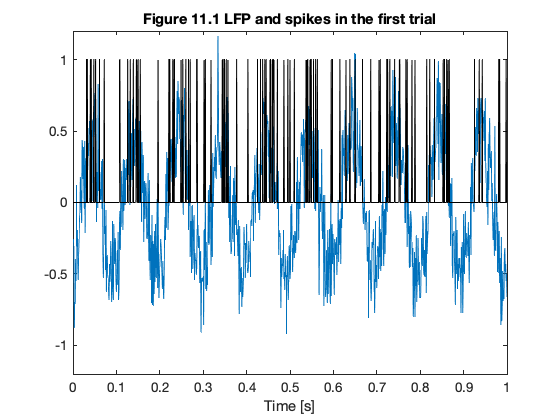

In [2]:
figure
plot(t, y(1, :))
hold on
plot(t, n(1, :), 'k')
hold off
ylim([-1, 1] * 1.2)
xlabel('Time [s]')
title('Figure 11.1 LFP and spikes in the first trial')


### Spike-triggered average (STA)

In [3]:
[t_sta, STA] = spike_triggered_average(n, y, t);


#### Plot STA

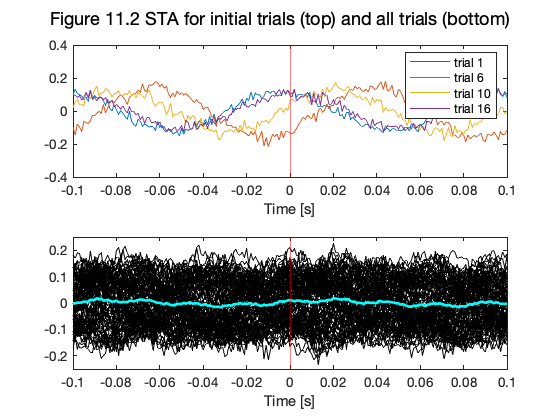

In [4]:
figure
subplot(2, 1, 1)
plot(t_sta, STA([1, 6, 10, 16], :)')
xlim tight
ylim([-1, 1] * 0.4)
hold on
plot([0, 0], ylim, 'r')
legend(["trial 1", "trial 6", "trial 10", "trial 16"])
xlabel('Time [s]')

subplot(2, 1, 2)
plot(t_sta, STA', 'k')
xlim tight
ylim([-1, 1] * 0.25)
hold on
plot(t_sta, mean(STA), 'c', linewidth = 2)
plot([0, 0], ylim, 'r')
xlabel('Time [s]')

sgtitle('Figure 11.2 STA for initial trials (top) and all trials (bottom)')


### Field-triggered average (FTA)

In [5]:
load('Ch11-spikes-LFP-1.mat') % load the multiscale dat

% 9-11 Hz
bp1 = [9, 11];
[FTA1, p] = field_triggered_average(n, y, t, bp1);

% 44-46 Hz
bp2 = [44, 46];
FTA2 = field_triggered_average(n, y, t, bp2);


#### Plot FTA

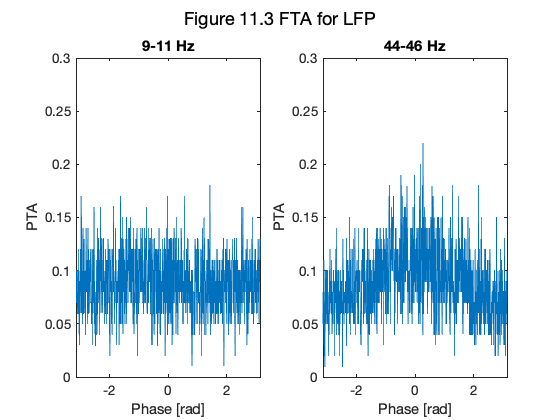

In [6]:
figure
subplot(1, 2, 1)
plot(p, mean(FTA1, 1))
xlim([-pi, pi])
ylim([0, .3])
xlabel('Phase [rad]')
ylabel('PTA')
title('9-11 Hz')

subplot(1, 2, 2)
plot(p, mean(FTA2, 1))
xlim([-pi, pi])
ylim([0, .3])
xlabel('Phase [rad]')
ylabel('PTA')
title('44-46 Hz')

sgtitle('Figure 11.3 FTA for LFP')


## Step 2 Spike-field coherency

### Add Chronux paths

In [7]:
addpath(genpath('~/Documents/Richard/ComputationalToolbox/neurophysiology_signals_analysis/chronux'))


### Load the data

In [8]:
load('Ch11-spikes-LFP-1.mat') % load the multiscale dat

### Estimate spke-field coherence using Chronux toolbox

In [9]:
N = size(y, 2);
dt = t(2) - t(1);
Fs = 1 / dt;
TW = 3;
ntapers = 2 * TW - 1;

% set the parameters of the MTM
params.Fs = Fs;
params.tapers = [TW, ntapers];
params.pad = -1;
params.trialave = 1;

% compute the MTM cohernence
[C, ~, ~, Syy, Snn, f] = coherencycpb(y.', n.', params);


#### Plot SFC

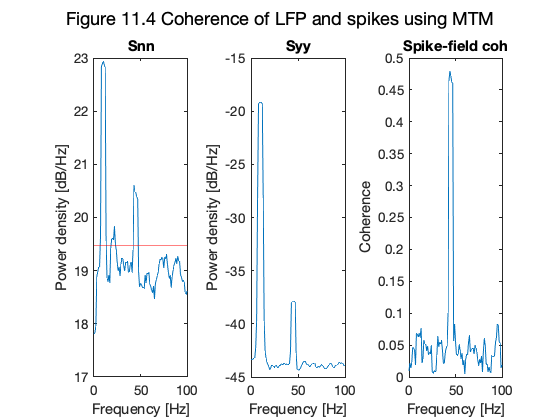

In [10]:
lambda = mean(sum(n, 2)) / (N * dt);

figure
subplot(1, 3, 1)
plot(f, pow2db(Snn))
hold on
plot(xlim, [1 1] * pow2db(lambda), 'r')
xlim([0, 100])
ylim([17, 23])
xlabel('Frequency [Hz]')
ylabel('Power density [dB/Hz]')
title('Snn')

subplot(1, 3, 2)
plot(f, pow2db(Syy))
xlim([0, 100])
ylim([-45, -15])
xlabel('Frequency [Hz]')
ylabel('Power density [dB/Hz]')
title('Syy')

subplot(1, 3, 3)
plot(f, C)
xlim([0, 100])
ylim([0, 0.5])
xlabel('Frequency [Hz]')
ylabel('Coherence')
title('Spike-field coh')

sgtitle('Figure 11.4 Coherence of LFP and spikes using MTM')


### Rescale LFP

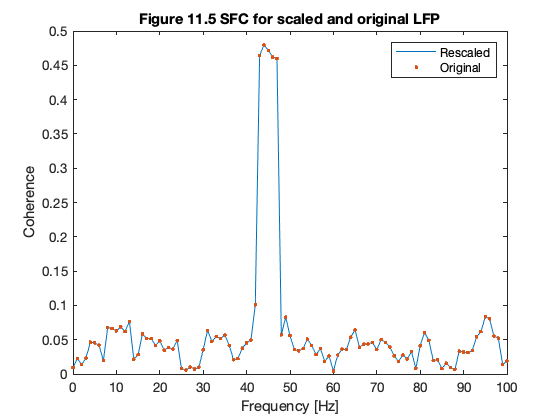

In [11]:
y_rs = .1 * y;
C_rs = coherencycpb(y_rs.', n.', params);

figure
plot(f, C_rs, f, C, '.')
legend({'Rescaled', 'Original'})
xlim([0, 100])
ylim([0 .5])
xlabel('Frequency [Hz]')
ylabel('Coherence')
title('Figure 11.5 SFC for scaled and original LFP')


### Rescale spike trains by thinning

In [12]:
load('Ch11-spikes-LFP-1.mat') % load the multiscale dat
dt = t(2) - t(1);
N = size(y, 2);

thinning_factor = 0:.05:.75; %Choose a thinning factor.
num_tf = length(thinning_factor);
lambda = zeros(1, num_tf);
C_tf = zeros(num_tf, length(f));

for j = 1:num_tf
    tf_j = thinning_factor(j);
    n_j = n;

    for k = 1:size(n_j, 1) %For each trial,
        spikes = find(n_j(k, :) == 1); %...find the spikes.
        n_spikes = length(spikes); %...determine # of spikes.
        spikes = spikes(randperm(n_spikes)); %...permute spikes indices,
        n_remove = floor(tf_j * n_spikes); %...# spikes to remove,
        n_j(k, spikes(1:1 + n_remove)) = 0; %... remove the spikes.
    end % for

    lambda(j) = mean(sum(n_j, 2)) / (N * dt);
    C_tf(j, :) = coherencycpb(y.', n_j.', params);

end % for


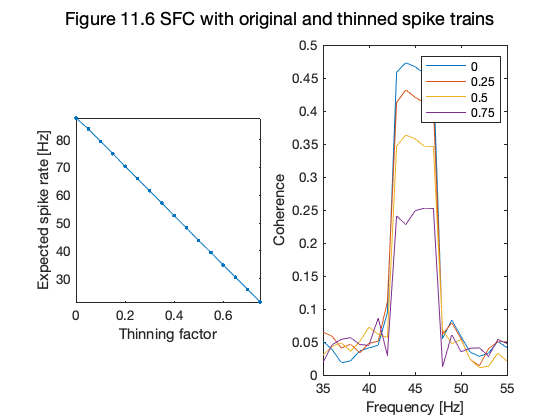

In [13]:
figure
subplot(1, 2, 1)
plot(thinning_factor, lambda, '.-')
axis tight
axis square
xlabel('Thinning factor')
ylabel('Expected spike rate [Hz]')

subplot(1, 2, 2)
idx = ismember(thinning_factor, [0, .25, .5, .75]);
plot(f, C_tf(idx, :).')
legend(["0", "0.25", "0.5", "0.75"])
xlim([35, 55])
ylim([0, .5])
xlabel('Frequency [Hz]')
ylabel('Coherence')

sgtitle('Figure 11.6 SFC with original and thinned spike trains')


## Step 3 Model of SFC using GLM

### Estimate the model parameters

In [14]:
load('Ch11-spikes-LFP-1.mat') % load the multiscale dat

phi0 = -pi:.01:pi;

% 9-11 Hz
pb1 = [9, 11]; %Set the passband,
[pta1, phase1, phi1] = field_triggered_average(n, y, t, pb1);
[md1, ev1] = spike_field_glm(n, phi1, EvalPhase = phi0);

fprintf('9-11 Hz, beta_1 p-value: %f, beta_2 p-value: %f\n', ...
    md1.stats.p(2), md1.stats.p(3))

% 44-46 Hz
pb2 = [44, 46]; %Set the passband,
[pta2, phase2, phi2] = field_triggered_average(n, y, t, pb2);
[md2, ev2] = spike_field_glm(n, phi2, EvalPhase = phi0);

fprintf('44-46 Hz, beta_1 p-value: %f, beta_2 p-value: %f\n', ...
    md2.stats.p(2), md2.stats.p(3))


9-11 Hz, beta_1 p-value: 0.261355, beta_2 p-value: 0.002441
44-46 Hz, beta_1 p-value: 0.000000, beta_2 p-value: 0.708745


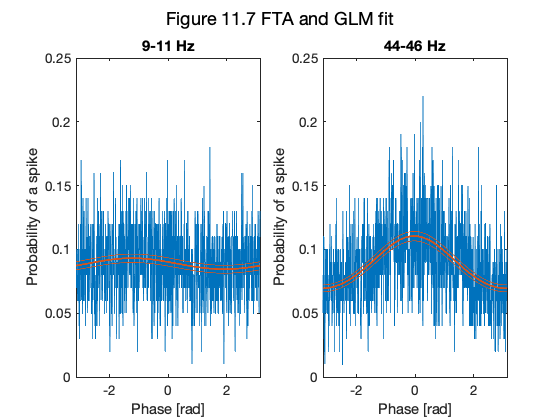

In [15]:
co = colororder();

figure
subplot(1, 2, 1)
y0 = ev1.y0;
dylo = ev1.dylo;
dyhi = ev1.dyhi;

plot(phase1, mean(pta1, 1), 'Color', co(1, :))
hold on
plot(phi0, y0, 'Color', co(2, :), 'LineWidth', 2)
plot(phi0, y0 + dylo, 'Color', co(2, :), 'LineWidth', 1)
plot(phi0, y0 - dyhi, 'Color', co(2, :), 'LineWidth', 1)
xlim tight
ylim([0 .25])
xlabel('Phase [rad]')
ylabel('Probability of a spike')
title('9-11 Hz')

subplot(1, 2, 2)
y0 = ev2.y0;
dylo = ev2.dylo;
dyhi = ev2.dyhi;

plot(phase2, mean(pta2, 1), 'Color', co(1, :))
hold on
plot(phi0, y0, 'Color', co(2, :), 'LineWidth', 2)
plot(phi0, y0 + dylo, 'Color', co(2, :), 'LineWidth', 1)
plot(phi0, y0 - dyhi, 'Color', co(2, :), 'LineWidth', 1)
xlim tight
ylim([0 .25])
xlabel('Phase [rad]')
ylabel('Probability of a spike')
title('44-46 Hz')

sgtitle('Figure 11.7 FTA and GLM fit')
